In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../Backend'))

import wahlrecht_polling_firms

%matplotlib inline

In [16]:
complete_data_dict = wahlrecht_polling_firms.get_tables()
data = complete_data_dict['allensbach']

In [4]:
class predict_till_election ():
    
    def __init__ (self, timeline = data, predict_f = 'montecarlo'):
        self.timeline = timeline
        self.funcs_dict = {'montecarlo': self.montecarlo}
        self.predict_f = self.funcs_dict[predict_f]
        self.election_date = pd.to_datetime('24.09.2017') #dt.date.strptime('24.09.2017', '%d.%m.%Y')
        self.weeks_left(timeline)
        self.parties  = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']
    
    def weeks_left(self, timeline):
        most_recent_poll = self.election_date  - pd.to_datetime (timeline['Datum']) #TODO: make sure it's always "Datum"
        
        self.weeks = int((most_recent_poll).astype('timedelta64[W]')[0])
    
    def montecarlo(self, iterations = 1000):
        print ((iterations,self.weeks,len(parties)))
        self.traces = np.empty ((iterations,self.weeks,len(parties)))
        
        covar = self.timeline[parties].cov()

        for i in range(iterations):
            self.traces[i] =self.n_days_predict(covar)
            if (100*i/iterations) == int ((100*i/iterations)):
                print ("\r %d" %(100*i/iterations), end = '')
        
    def n_days_predict (self, covar):
        trace = np.empty((self.weeks,len(parties)))
        
        props = self.timeline[parties].iloc[0]
        trace [0] = props
        
        for i in range (1,self.weeks):
            props+=np.random.multivariate_normal(np.zeros(len(parties)) , covar)
            props[props<0]=0
            props= props/(props.sum()) *100
            trace[i] = props
        return trace

In [5]:
test = predict_till_election()

In [12]:
test.montecarlo(5000)

(5000, 17, 7)
 99

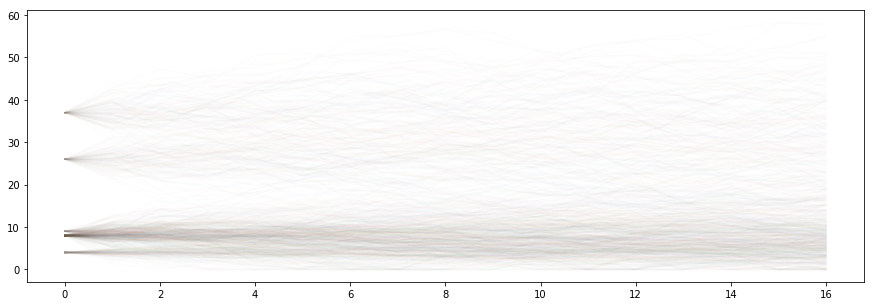

In [10]:
plt.figure(figsize=(15,5))

for trace in test.traces:
    for party in trace.T:
        plt.plot(party, alpha = 0.01)

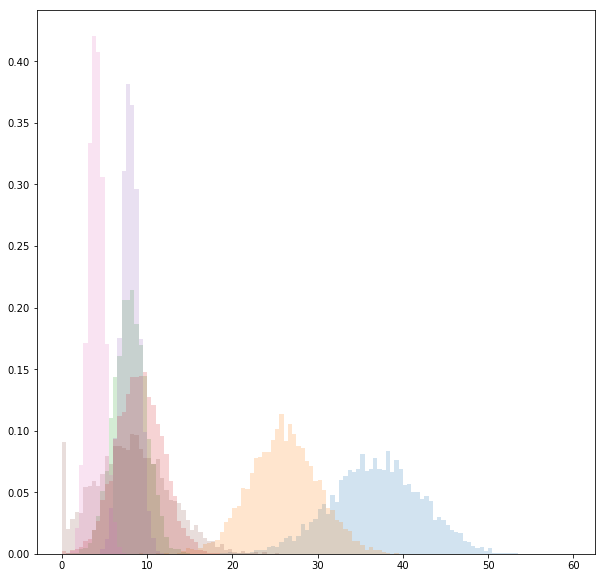

In [15]:
summ = 0

plt.figure(figsize=(10,10))
   
for i in range (len(parties)):
    count,bins, _ = plt.hist(test.traces[:,3,i],bins=np.arange(0,60,.5),normed=True, alpha=.2)
